<a href="https://colab.research.google.com/github/RafaelYang/NTUNHS_Artificial-Intelligence/blob/main/Final%20Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data

In [ ]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

#Get data
df = pd.read_csv\
    ("/content/drive/MyDrive/NTUNHS_AI/Final Report/Raw Data/parkinsons.csv")

#get information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          240 non-null    object 
 1   Recording   240 non-null    int64  
 2   Status      240 non-null    int64  
 3   Gender      240 non-null    int64  
 4   Jitter_rel  240 non-null    float64
 5   Jitter_abs  240 non-null    float64
 6   Jitter_RAP  240 non-null    float64
 7   Jitter_PPQ  240 non-null    float64
 8   Shim_loc    240 non-null    float64
 9   Shim_dB     240 non-null    float64
 10  Shim_APQ3   240 non-null    float64
 11  Shim_APQ5   240 non-null    float64
 12  Shi_APQ11   240 non-null    float64
 13  HNR05       240 non-null    float64
 14  HNR15       240 non-null    float64
 15  HNR25       240 non-null    float64
 16  HNR35       240 non-null    float64
 17  HNR38       240 non-null    float64
 18  RPDE        240 non-null    float64
 19  DFA         240 non-null    f

# Data preprocessing

Train dataset & Test dataset

In [ ]:
size = df['Status'].value_counts()
pct = df['Status'].value_counts(normalize=True).round(2)
pd.DataFrame(zip(size,pct),columns=['Times','Percentage'])

,Times,Percentage
0,120,0.5
1,120,0.5


In [ ]:
from sklearn.model_selection import train_test_split

X_cols = df.columns.drop(['ID','Status'])
X = df[X_cols]
y=df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, 
                                                    random_state=42)
print('Train:',len(X_train))
print('Test:',len(X_test))
print('The percentage of the Test to Total: %.1f'%(len(X_test)/len(X)*100),'%')

Train: 160
Test: 80
The percentage of the Test to Total: 33.3 %


# Hypothesis 1

Men are more likely to get PD

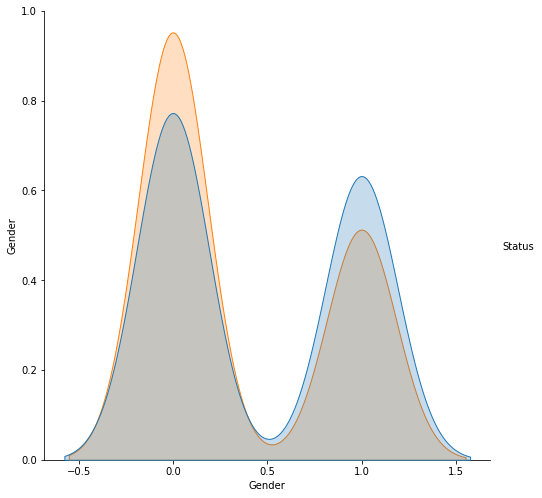

In [ ]:
sns.pairplot(df,hue='Status',vars=['Gender'],size=7)

# Hypothesis 2

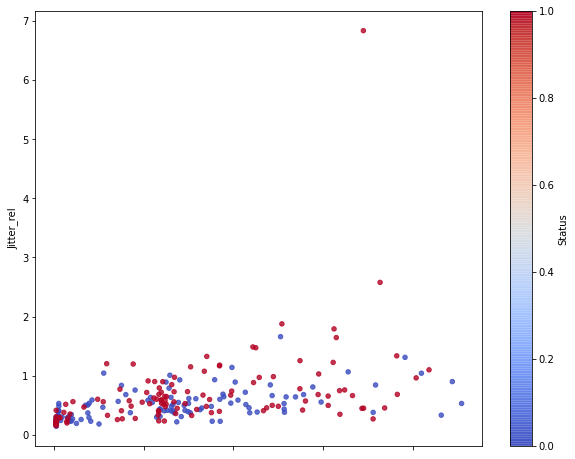

In [ ]:
df.plot(kind='scatter', x='PPE', y='Jitter_rel', 
        c='Status',cmap='coolwarm', 
        alpha=0.8,figsize=(10,8))

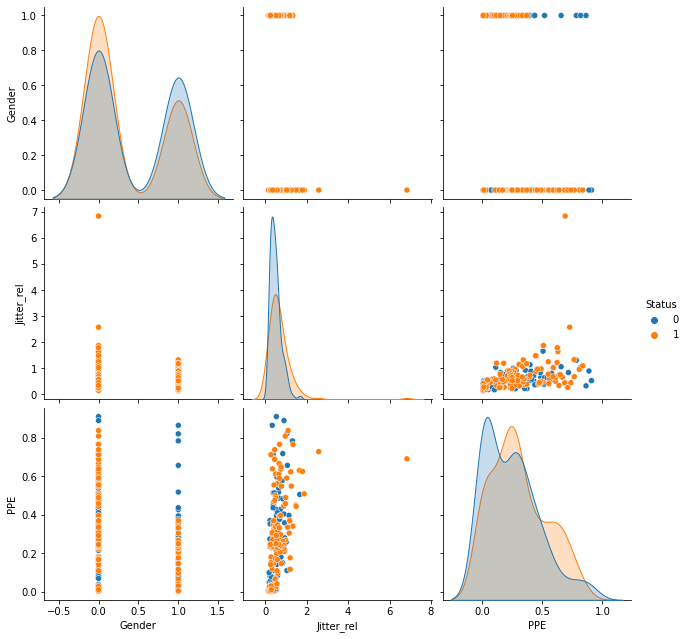

In [ ]:
sns.pairplot(df,hue='Status',vars=['Gender','Jitter_rel','PPE'],size = 3)

# Hypothesis 3

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

#standardize the data and use logistic regression
model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear'))
])

#train the Train data set
model_pl.fit(X_train, y_train)
y_pred = model_pl.predict(X_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame
      (cm, 
       index=['Correct 0', 'Correct 1'], columns=['Predict 0', 'Predict 1']))
print('Accuracy(Logis): %d'%(accuracy_score(y_test, y_pred)*100) + '%')

#compare with actual data(only the last five records)
print('\n Last five records:')
pd.DataFrame(zip(y_test, y_pred), columns=['Correct','Predict']).tail() 

           Predict 0  Predict 1
Correct 0         30         10
Correct 1          6         34
Accuracy(Logis): 80%

 Last five records:


,Correct,Predict
75,0,0
76,0,0
77,0,1
78,1,1
79,1,1


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

#define predict function
def predict(param):
  model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression ())
  ])
  model_pl.set_params(**param)
  model_pl.fit (X_train, y_train) 
  return model_pl.score(X_test, y_test)

#use LogisticRegression/SVC/
#KNeighborsClassifier/DecisionTreeClassifier
param_grid=[
  {'model': [LogisticRegression ()], 'model__penalty': ['11', '12'],
   'model__C': [0.001, 0.01,1,5,10]}, 
  {'model': [SVC()], 'model__kernel': ['linear', 'rbf'],
   'model__C': [0.1, 1, 10, 100, 1000],
   'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
  {'model': [KNeighborsClassifier ()],
   'model__n_neighbors': [5,10,15,20,25]}, 
  {'model': [DecisionTreeClassifier ()],
   'model__min_samples_split': [5, 10, 15, 20, 30]}
]

model_pl = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression)
])

gs = GridSearchCV(model_pl, param_grid=param_grid ,
                  cv=10,return_train_score=True)

#training
gs.fit(X_train,y_train)

#use Grid SearchCV to cross analysis and print first ten results
df_cv = pd.DataFrame (gs.cv_results_)[['params', 'mean_test_score']].\
sort_values(by = 'mean_test_score', ascending=False)
df_cv_top10= df_cv.iloc[:10]

#print regression name
df_cv_top10 ['model_name'] = df_cv_top10 ['params'].\
apply(lambda x: x['model'].__class__.__name__)

#print accuracy

df_cv_top10['accuracy'] = df_cv_top10 ['params'].apply(predict)
df_cv_top10 = df_cv_top10.set_index('model_name')\
              [['mean_test_score','accuracy']]

df_cv_top10

,mean_test_score,accuracy
model_name,,
KNeighborsClassifier,0.81875,0.8500
SVC,0.81250,0.8750
SVC,0.81250,0.8250
KNeighborsClassifier,0.81250,0.8375
KNeighborsClassifier,0.81250,0.8250
SVC,0.80625,0.8500
KNeighborsClassifier,0.80000,0.8500
SVC,0.80000,0.8750
SVC,0.80000,0.8375


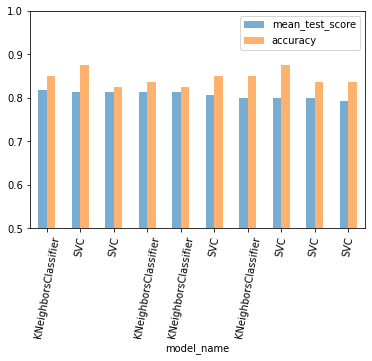

In [ ]:
df_cv_top10.plot(kind='bar',ylim=(0.5,1),alpha=0.6,rot=80)

# Hypothesis 4

Finding feature in data set through randomForestClassifier

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
X_col_num = X.select_dtypes(exclude = 'object').columns
data_pl= ColumnTransformer([('num',StandardScaler(),X_col_num)])

model_pl_rf = Pipeline([
  ('preprocess', data_pl),
  ('model',RandomForestClassifier(random_state=42))
])

model_pl_rf.fit(X_train, y_train)

imp = model_pl_rf.named_steps['model'].feature_importances_
feature_names = model_pl_rf.named_steps['preprocess']
cols = X_col_num.tolist() 
pd.DataFrame(zip(cols,imp), columns=['Column','coefficient']).\
sort_values(by='coefficient', ascending=False).head().round (3)

,Column,coefficient
27,MFCC7,0.075
24,MFCC4,0.057
25,MFCC5,0.043
36,Delta3,0.043
32,MFCC12,0.043


# Hypothesis 5

Top five important coefficient(Using DecisionTreeClassifier)

In [ ]:
model_tree = DecisionTreeClassifier (max_depth=10)
model_tree.fit(X_train, y_train)
pd.Series(model_tree.feature_importances_, 
           index=X.columns).sort_values(ascending=False).head()

Delta0    0.368443
MFCC4     0.096259
GNE       0.074528
HNR35     0.068948
MFCC3     0.061407
dtype: float64

Decision Tree

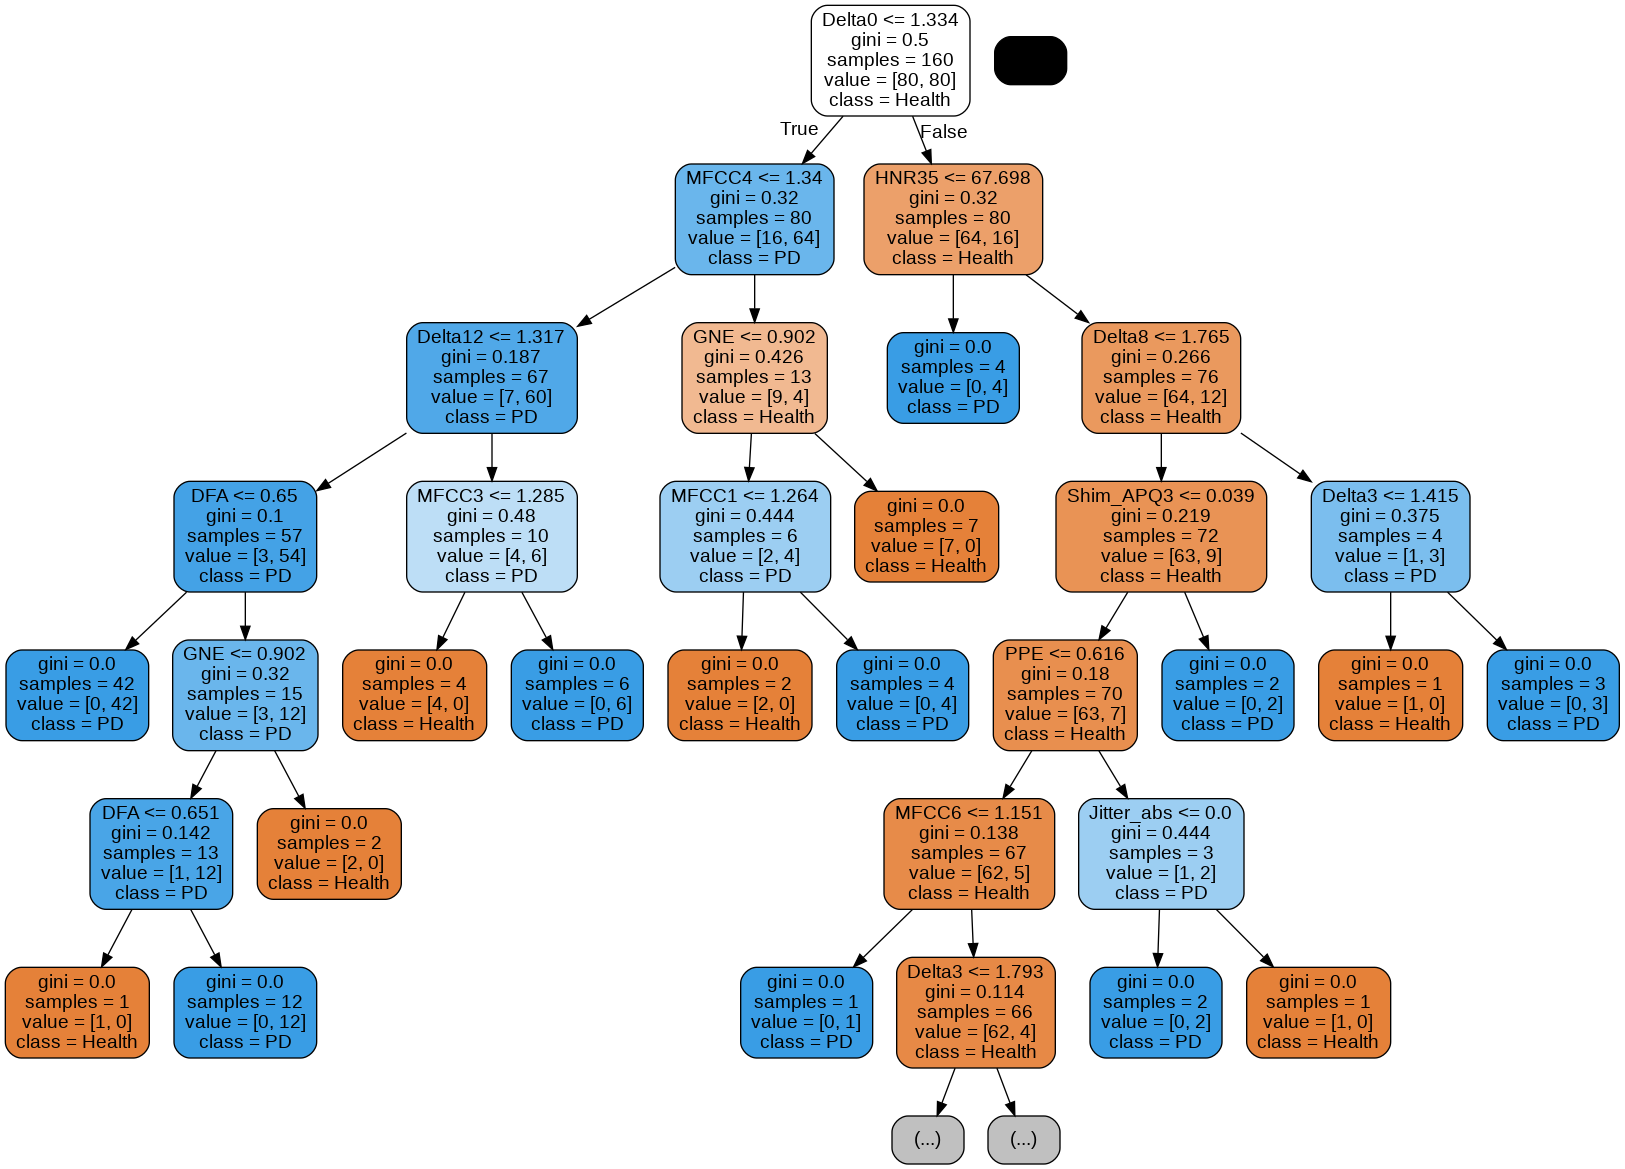

In [ ]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

#Setting tree
model_tree = DecisionTreeClassifier (max_depth=10)
model_tree.fit(X_train, y_train)

features = X.columns
class_names = ['Health','PD'] #0:Health,1:PD

dot_data = export_graphviz(model_tree, out_file=None,
                           feature_names=features,
                           class_names = class_names, 
                           proportion = False, filled=True,
                           max_depth=6,
                           rounded=True)

graph = pydot.graph_from_dot_data(dot_data)
graph[0].write_png('PD.png') 
Image(graph[0].create_png(), width=1000)